In [ ]:
# Script to tryout alexnet for the whole tactile images
# Images should be loaded into a range bw [0,1] and normalized with mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [1]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in /home/irmak/.cache/torch/hub/pytorch_vision_v0.10.0


mod_name: collections, name: OrderedDict
mod_name: torch._utils, name: _rebuild_parameter
mod_name: torch._utils, name: _rebuild_tensor_v2


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
from torchvision import models
import torch.nn as nn

# Remove the last layer of alexnet
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(4096, 512, bias=True)
)

In [10]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
mock_data = torch.rand((2,3,224,224))
output = model(mock_data)
print(output.shape)

torch.Size([2, 512])


In [4]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as T 
import torch.nn.functional as F

from torchvision.datasets.folder import default_loader as loader 
from torch.utils import data

from tactile_learning.utils.constants import *
from tactile_learning.utils.data import load_data

# Get the tactile image whole dataset - TODO: If this works add this to the code base as well
class TactileWholeHandDataset(data.Dataset): # Dataset that will return 16x3,4,4 images - stacked cnn
    def __init__(
        self,
        data_path,
        img_size=16,
        normalize=False,
        stats=[TACTILE_IMAGE_MEANS, TACTILE_IMAGE_STDS], # Will have image means and stds
    ):
        super().__init__()
        self.roots = glob.glob(f'{data_path}/demonstration_*')
        self.roots = sorted(self.roots)
        self.data = load_data(self.roots, demos_to_use=[])
        self.normalize = normalize
        self.resize_transform = T.Resize((img_size, img_size))
        self.normalization_transform = T.Normalize(stats[0], stats[1])

    def __len__(self):
        return len(self.data['tactile']['indices'])

    def _get_whole_hand_tactile_image(self, tactile_values): 
        # tactile_values: (15,16,3)
        # turn it into 16,16,3 by concatenating 0z
        tactile_image = torch.FloatTensor(tactile_values)
        tactile_image = F.pad(tactile_image, (0,0,0,0,1,0), 'constant', 0)
        # reshape it to 4x4
        tactile_image = tactile_image.view(16,4,4,3)

        # concat for it have its proper shape
        tactile_image = torch.concat([
            torch.concat([tactile_image[i*4+j] for j in range(4)], dim=0)
            for i in range(4)
        ], dim=1)

        tactile_image = torch.permute(tactile_image, (2,0,1))

        return self.resize_transform(tactile_image)

    def __getitem__(self, index):
        # Get the tactile image
        demo_id, tactile_id = self.data['tactile']['indices'][index]
        tactile_values = self.data['tactile']['values'][demo_id][tactile_id]
        tactile_image = self._get_whole_hand_tactile_image(tactile_values)

        if self.normalize:
            return self.normalization_transform(tactile_image)
        else:
            return tactile_image

    def getitem(self, index):
        return self.__getitem__(index) # NOTE: for debugging purposes
    

In [5]:
PLAY_DATA_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/tactile_play_data'
dset = TactileWholeHandDataset(
    data_path = PLAY_DATA_DIR,
    img_size = 224, # For alexnet
    normalize = True
)

In [7]:
# First get the minimum and maximum of the images - and visualize them
tactile_loader = data.DataLoader(dset, 
                                batch_size  = 32, 
                                shuffle     = True, 
                                num_workers = 4,
                                pin_memory  = True)

In [8]:


    
min_tactile = 13534
max_tactile = -13834
for batch in tactile_loader:
    curr_min = batch.min() 
    curr_max = batch.max()
    if curr_min < min_tactile:
        min_tactile = curr_min 
    if curr_max > max_tactile: 
        max_tactile = curr_max

print(min_tactile, max_tactile)
    
    

tensor(-112.1339) tensor(99.1087)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


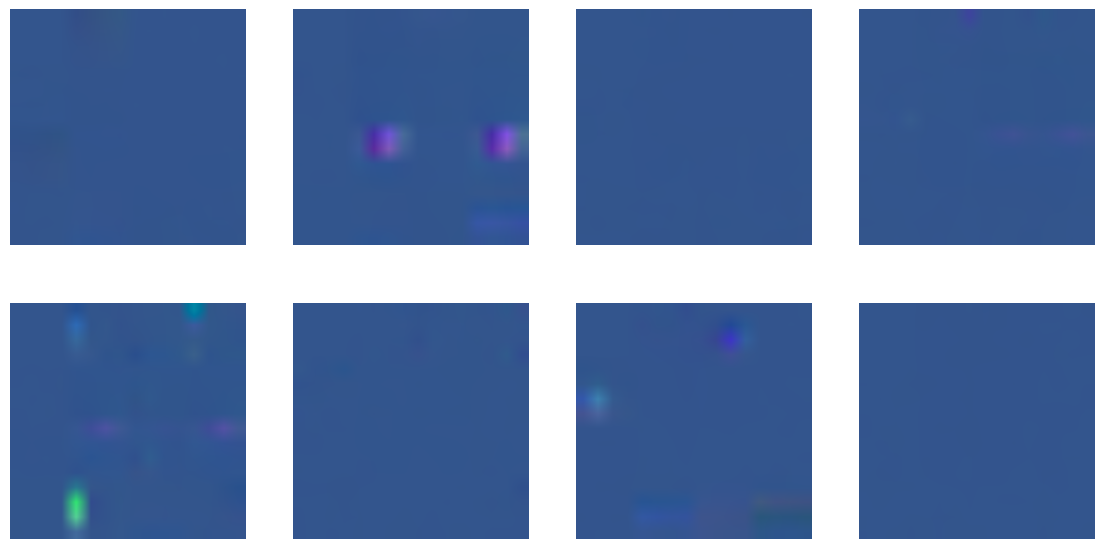

In [19]:
# display images
def plot_tactile_image(ax, tactile_image, scale=False, tactile_min=None, tactile_max=None): # Tactile image should be tensor
    if scale:
        img_range = tactile_max - tactile_min
        tactile_image = (tactile_image - tactile_min) / img_range
    npimg = tactile_image.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

preprocess = T.Compose([
    T.Resize(224),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
for batch_idx, inputs in enumerate(tactile_loader):
    img_range = max_tactile - min_tactile
    inputs = (inputs - min_tactile) / img_range
    inputs = preprocess(inputs)
    fig = plt.figure(figsize = (14, 7))
    for i in range(8):
        ax = fig.add_subplot(2, 4, i + 1, xticks = [], yticks = [])  
        plot_tactile_image(ax, inputs[i])
    break

In [2]:
import glob
import h5py
import hydra
import mmap
import numpy as np
import os
import pickle
import torch 
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.utils.data as data 

from omegaconf import DictConfig, OmegaConf
from collections import OrderedDict
from tqdm import tqdm 
from torch.nn.parallel import DistributedDataParallel as DDP
from torchvision import models
from holobot.robot.allegro.allegro_kdl import AllegroKDL

from tactile_learning.utils.constants import *
from tactile_learning.models.custom import *
from tactile_learning.datasets.tactile_vision import *
from tactile_learning.deployment.load_models import * 
from tactile_learning.deployment.nn_buffer import NearestNeighborBuffer
from tactile_learning.models.knn import KNearestNeighbors, ScaledKNearestNeighbors
from tactile_learning.utils.visualization import *
from tactile_learning.utils.tactile_image import *
from torchvision.transforms.functional import crop

In [1]:
from tactile_learning.datasets.tactile import TactileBYOLDataset
from tactile_learning.utils.constants import TACTILE_IMAGE_STATS
GAMEPAD_DATA_DIR = '/home/irmak/Workspace/Holo-Bot/extracted_data/gamepad/right/eval'
whole_hand_dset = TactileBYOLDataset(
    data_path = GAMEPAD_DATA_DIR,
    img_size = 224,
    tactile_information_type = 'whole_hand',
    mean_std = [TACTILE_IMAGE_STATS['play_data']['mean'], TACTILE_IMAGE_STATS['play_data']['std']],
    min_max = [TACTILE_IMAGE_STATS['play_data']['min'], TACTILE_IMAGE_STATS['play_data']['max']]
)

In [6]:
# Load the model
ALEXNET_OUT_DIR = '/home/irmak/Workspace/tactile-learning/tactile_learning/out/2023.01.18/17-06_tactile_byol_bs_512_tactile_play_data_alexnet_clamped'
os.environ["MASTER_ADDR"] = "localhost"
os.environ["MASTER_PORT"] = "29506"

torch.distributed.init_process_group(backend='gloo', rank=0, world_size=1)
torch.cuda.set_device(0)
device = torch.device('cuda:0')

out_dir = ALEXNET_OUT_DIR
cfg = OmegaConf.load(os.path.join(out_dir, '.hydra/config.yaml'))
model_path = os.path.join(out_dir, 'models/byol_encoder_best.pt')
device = torch.device('cuda:0')
encoder = load_model(cfg, device, model_path)


cfg.learner_type: tactile_byol


Using cache found in /home/irmak/.cache/torch/hub/pytorch_vision_v0.10.0


mod_name: collections, name: OrderedDict
mod_name: torch._utils, name: _rebuild_parameter
mod_name: torch._utils, name: _rebuild_tensor_v2


In [7]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]) 

In [8]:
tactile_loader = data.DataLoader(
    whole_hand_dset, 
    batch_size  = 32, 
    shuffle     = True, 
    num_workers = 4,
    pin_memory  = True
)

In [9]:
batch = next(iter(tactile_loader))

In [12]:
transformed_batch = transform(batch)

In [13]:
output = encoder(transformed_batch)

In [19]:
sum(output[1] - output[3])

tensor(-0.0009, device='cuda:0', grad_fn=<AddBackward0>)

In [21]:
# sample execution (requires torchvision)
preprocess = T.Compose([
    # transforms.Resize(256),
    # transforms.CenterCrop(224),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



# move the input and model to GPU for speed if available


for batch_idx, inputs in enumerate(tactile_loader):
    print('inputs.shape: {}'.format(inputs.shape))
    img_range = max_tactile - min_tactile
    inputs = (inputs - min_tactile) / img_range
    if torch.cuda.is_available():
        inputs = inputs.to('cuda')
        model.to('cuda')
        
    with torch.no_grad():
        output = model(inputs)
        
    print('output.shape: {}'.format(output.shape))
    break


# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
# probabilities = torch.nn.functional.softmax(output[0], dim=0)
# print(probabilities)

inputs.shape: torch.Size([32, 3, 224, 224])
output.shape: torch.Size([32, 1000])
tensor([-7.9275e-01,  9.4470e-01, -1.5069e+00, -1.6408e+00, -7.5520e-01,
         1.1387e-01, -2.5467e+00, -1.3912e-01, -2.2648e+00, -6.3195e-03,
         1.4627e+00,  7.0336e-01,  2.0990e-01,  1.9693e-01, -4.9721e-01,
        -4.6372e-01,  7.0187e-01, -9.6748e-01, -3.8108e-01,  1.7180e-01,
         2.2447e-01,  2.1981e+00,  7.4972e-01, -2.8371e-02, -1.3842e-01,
        -9.7830e-01, -1.8382e-01, -1.6004e-01, -2.0830e-01, -6.0412e-02,
        -1.6127e+00,  3.9980e-02, -9.2993e-01, -7.8887e-01, -9.7627e-01,
        -2.0505e+00, -3.5103e-02, -1.6683e+00,  1.5700e+00, -1.1540e+00,
        -7.7959e-01, -4.9018e-01,  1.9904e+00,  1.4399e+00, -5.9023e-01,
        -5.6342e-01, -6.5846e-01,  3.3001e-01, -2.0446e+00, -1.5656e+00,
        -1.4014e+00, -7.3611e-01,  8.4861e-01,  5.6708e-01, -3.8263e-01,
        -1.0599e+00, -3.9390e-01, -1.1229e+00,  2.9475e-01,  1.4288e+00,
        -9.8462e-01, -1.3175e+00,  4.6416e-